In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.linalg import solve_continuous_are as are
from scipy.linalg import solve_lyapunov as lya
from scipy.optimize import bisect

sys.path.append("../model")
sys.path.append("../control")
sys.path.append("../analysis")
from networks import *
from analysis_util import *

from kooc_fns import *
from ilqr_fns import *
from control_util import *
%load_ext autoreload
%autoreload 2

In [3]:
model_names = ["d-latent-exp-1", "d-latent-exp-2"]
model_labels = [r"$N=20$", r"$N=50$"]
PATH = "../saved/logs/models/denis-latent-exp/pendulum"
x_true = np.load('../data/raw_data/affine/pend_val.npy')

models, model_configs = load_models([DENIS]*2, PATH, model_names)

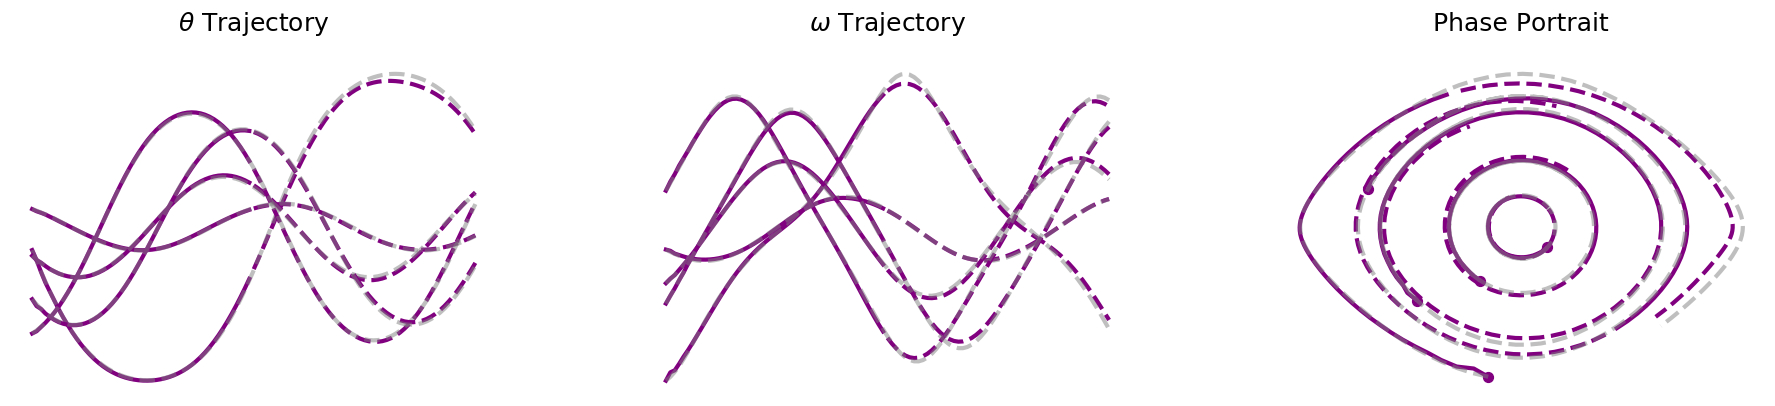

In [4]:
_ = plot_trajectories(models[1], 50, x_true)

In [5]:
model = models[1]
kooc = KOOC('pendulum', model, 0.1)
idx = np.random.randint(0, len(x_true), 50)
init_cond = x_true[idx, 0:1, :]
x_goal = [0, 0]
results = model.predict(init_cond, 1, return_ko=True)
kos = results[-1]

In [8]:
idx = np.random.randint(0, len(x_true), 10)
init_cond = x_true[idx, 0:1, :]
x_goal = [np.pi, 0]
model = models[1]
qs = [5, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Qs = [[q, 0] for q in qs]

In [9]:
results = kooc_eval(model, init_cond, x_goal, 100, Qs[:2])

100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


In [10]:
results = kooc_eval(model, init_cond, x_goal, 100, Qs)
results2 = ilqr_eval(init_cond, x_goal, 100, Qs)

100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


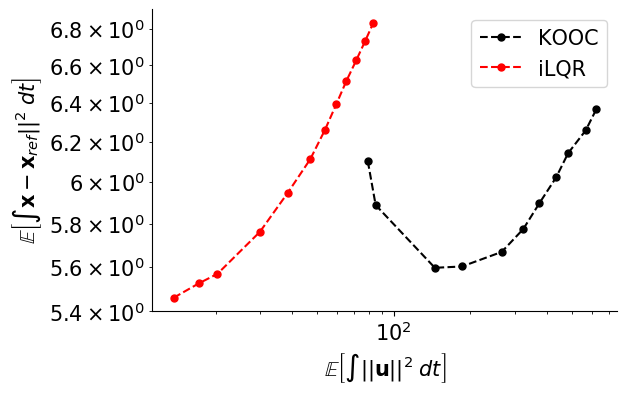

In [13]:
fig, ax = plt.subplots(1, 1, dpi=100)

ax.plot(results[1][1:], results[0][1:], '--.', markersize=10, label='KOOC', color='k')
ax.plot(results2[1], results2[0], '--.', markersize=10, label='iLQR', color='r')

ax.set_xlabel(r'$\mathbb{E}\left[\int \|\|\mathbf{u}\|\|^2 \; dt\right]$')
ax.set_ylabel(r'$\mathbb{E}\left[\int \mathbf{x}-\mathbf{x}_{ref}\|\|^2 \; dt \right]$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

In [12]:
ilqr = ILQR('pendulum', 0.1)
x_ilqr, u_ilqr, t = ilqr.simulate(init_cond, x_goal, 100, [10, 1], 1)

kooc = KOOC('pendulum', model, 0.1)
x_kooc, u_kooc, t, t_kooc = kooc.simulate(init_cond, x_goal, 100, [10, 0], r=1)

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


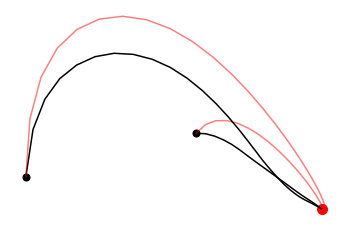

In [14]:
fig, ax = plt.subplots(1, 1)
for i in range(2):
    ax.plot(x_kooc[i, :, 0], x_kooc[i, :, 1], color='k')
    ax.plot(x_ilqr[i, :, 0], x_ilqr[i, :, 1], color='r', alpha=0.5)
    ax.scatter(x_ilqr[i, 0, 0], x_ilqr[i, 0, 1], color='k', s=50)
    ax.scatter(x_kooc[i, -1, 0], x_kooc[i, -1, 1], color='k', s=10)
ax.scatter([x_goal[0]], [x_goal[1]], color='r', s=100)
ax.axis('off')
plt.show()

In [ ]:
animate(['KOOC, iLQR'], 'kooc_slow', x_kooc, x_ilqr)